## Preamble

Import modules, define classes and functions and constants, etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import ws3.forest, ws3.core
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
data_path = 'data/input'
# fert_codes = ['00',
#               '11',
#               '12',
#               '13',
#               '14',
#               '15',
#               '16',
#               '17',
#               '21',
#               '22',
#               '23',
#               '24',
#               '25',
#               '26',
#               '31',
#               '32',
#               '33',
#               '34',
#               '35']
period_length = 10
max_age = 350
base_year = 2020
horizon = 10
# curve_table = pd.read_csv('%s/curve_table.csv' % data_path)
model_name = 'tsa24_clipped'
harvest_acode = 'cc'

# Create a new `ForestModel` instance

In [ ]:
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=data_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [29]:
fm.import_landscape_section()

In [30]:
fm.import_areas_section()

0

In [31]:
fm.import_yields_section()

Note that we have to manually flag the `cc` action as a harvest action (or it will not pass the `is_harvest` gate in `cmp_c_z` when building the optimization model (and there will be no harvest volume to optimize, etc). Currently no way to do this automatically in the `import_actions_section` method, but will try to include something later to avoid having to remember to do this. 

In [32]:
fm.import_actions_section()
fm.actions[harvest_acode].is_harvest = True

Add a "null" action (does nothing). Needed for optimization functions to work. Sort of an obscure design, but that is the way ws3 is implemented for the moment so just roll with it.

In [33]:
fm.add_null_action()

In [34]:
fm.import_transitions_section()

In [35]:
fm.compile_actions()

In [36]:
fm.initialize_areas()
fm.reset_actions()

# Define a base scenario (add optimization problem)

First we need to define a few utility functions that we will use to build the problems (e.g., objective function coefficient function, even flow constraint coefficient function, general constraint coefficient function).

Note that the `spades_ws3` project contains several useful chunks of code that you can use as a starting point (on GitHub, see link below).

https://github.com/gparadis/spades_ws3/blob/master/python/spadesws3.py

In [37]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for actionned area (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for actionned area (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, list of action codes, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            #import pdb
            #pdb.set_trace()
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`). 

Note how we use `functools.partial` to specialize the more general functions defined above for use in the `coeff_funcs` arg of `ForestModel.add_problem`. Otherwise we would have to define an entirely new function each time we defined a slightly different objective or constraint in one of our scenarios, which would get tedious and messy. The tedium and mess would be more evident if we had a large number of alternative scenarios defined in the same notebook (which we do not here, but use your imagination). 

Note also that the expected data structures for the various args to `ForestModel.add_problem` must be matched exactly or `ws3` will likely crash somewhere in one of the series of complicated private optimization model-building methods that get called from `ForestModel.add_problem`. You _should not_ have to unpack the exact logic of this model-building code to figure out why your model is crashing... it really is quite complicated and hard to follow. If you model is crashing there, you probably fed invalid (or incorrectly structured) args to `ForestModel.add_problem`. Carefully review the structure and values of your args to find the problem. I left some notes below (and some comments in the `_gen_scen_base` function code) to help clarify the expected arg structure, and will work on expanding the docstrings in the `ws3` source code so this is less obscure going forward.

I also had to patch the `ws3` code in two places so that it would "grow" correctly with the model set up to use _years_ as the age unit. For some reason the latest `dev` branch of `ws3` on GitHub was in some sort of intermediate state between using _periods_ and _years_ as the age unit. Originally `ws3` was implemented to import and simulate legacy Woodstock model input datasets, so it used _periods_ as the age unit (like Woodstock). At some point I think I hastily patched `ws3` to use _years_ as the age unit to make it work with `spades_ws3` for specific projects that needed to get done and delivered... if I recall we set the period length to 1 year for all those projects so it "just worked", but now we have a bit of a mess. Oops. Ultimately, I will need to revert `ws3` back to using Woodstock-compatible _period_ age unit (but make sure that the `spatial` module can still spatially and temporally disaggregate the aspatial periodic solutions from the Model I LP optimization problems into year-length time slices (maybe with age optionally expressed in years in output from this, for compatibility with downstream linked models like `SpaDES`). This is just a side-effect of many iterations of re-purposing `ws3` to work in a long (ad hoc) sequence of real research projects that had very specific input and output data specs. It is actually remarkable that `ws3` is not _more_ of a mess than it currently is, given the history and essentially null development budget. Use

`ForestModel.add_problem` arg specs are described below.

`name`: String. Used as key to store `Problem` instances in a dict in the `ForestModel` instanace, so make sure it is unique within a given model or you will overwrite dict values (assuming you want to stuff multiple problems, and their solutions, into your model at the same time). 
    
`coeff_funcs`: Dict of function references, keyed on _row name_ strings. These are the functions that generate the LP optimization problem matrix coefficients (for the objective function and constraint rows). This one gets complicated, and is a likely source of bugs. Make sure the row name key strings are all unique or you will make a mess. You can name the constraint rows anything you want, but the objective function row has to be named `z`. All coefficient functions must accept exactly two args, in this order: a `ws3.forest.ForestModel` instance and a `ws3.common.Path` instance. The `z` coefficient function is special in that it must return a single float value. All other (i.e., constraint) coefficient functions just return a dict of floats, keyed on period ints (can be sparse, i.e., not necessary to include key:value pairs in output dict if value is 0.0). It is useful (but not necessary) to use `functools.partial` to specialize a smaller number of more general function definitions (with more args, that get "locked down" and hidden by `partial`) as we have done in the example in this notebook.

`cflw_e`: Dict of `(dict, int)` tuples, keyed on _row name_ strings (must match _row name_ key values used to define coefficient functions for flow constraints in `coeff_func` dict), where the int:float dict embedded in the tuple defines epsilon values keyed on periods (must include all periods, even if epsilon value is always the same). See example below. 

```
{
  'cflw_acut':({1:0.01, 2:0.01, ..., 10:0.01}, 1),
  'cflw_vcut':({1:0.05, 2:0.05, ..., 10:0.05}, 1)
}
```

`cgen_data`: Dict of dict of dicts. The outer-level dict is keyed on _row name_ strings (must match row names used in `coeff_funcs`. The middle second level of dicts always has keys `'lb'` and `'ub'`, and the inner level of dicts specifies lower- and upper-bound general constraint RHS (float) values, keyed on period (int).

`acodes`: List of strings. Action codes to be included in optimization problem formulation (actions must defined in the `ForestModel` instance, but can be only a subset).

`sense`: Must be one of `ws3.opt.SENSE_MAXIMIZE` or `ws3.opt.SENSE_MINIMIZE`.

`mask`: Tuple of strings constituting a valid mask for your `ForestModel` instance. Can be `None` if you do not want to filter `DevelopmentType` instances.

In [74]:
def _gen_scen_base(fm, name='base', util=0.85, harvest_acode='cc',  
                   tvy_name='volume', obj_mode='max_hvol', mask=None):
    from functools import partial
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}

    # define list of action codes
    acodes = ['null', harvest_acode]  
    
    # define volume expression
    vexpr = '%s * %0.2f' % (tvy_name, util)

    # switch between 'max harvest volume' and 'min harvest area' objective function modes
    if obj_mode == 'max_hvol':
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_harea':
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)

    # define objective function coefficient function
    coeff_funcs['z'] = partial(cmp_c_z, expr=zexpr) 
    
    T = fm.periods
    
    # define even flow constraint (on harvest volume)
    cname = 'cflw_acut'
    e = 0.01 # epsilon parameter defining flow constraint tightness
    coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
    cflw_e[cname] = {t:e for t in T}, 1 # define flow constraint relative to period 1     
    
    # define even flow constraint (on harvest area)
    cname = 'cflw_vcut'
    e = 0.01 # epsilon parameter defining flow constraint tightness
    coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
    cflw_e[cname] = {t:e for t in T}, 1 # define flow constraint relative to period 1         
    
    # define general constraint (growing stock)
    cname = 'cgen_gs'
    lb, ub = 0., 1000000000000.
    coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
    cgen_data[cname] = {'lb':{t:lb for t in T}, 'ub':{t:ub for t in T}}
    
    
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)


In [75]:
def gen_scen(fm, name='base', util=0.85, harvest_acode='cc', tvy_name='volume', obj_mode='max_hvol', mask=None, **kwargs):    
    dsp = {'base':_gen_scen_base}
    return dsp[name](fm, name, util, harvest_acode, tvy_name, obj_mode, mask, **kwargs)
    #return dsp[name](fm, *args, **kwargs)


In [76]:
p = gen_scen(fm)

You will need to have `gurobipy` installed for this next step to work. At some point I will finish implementing bindings to the PuLP open-source solver library, but for now we are stuck with Gurobi as the only solver that works with ws3. 

You should be able to install `gurobipy` by uncommenting the magic `%pip` command below.

In [ ]:
#%pip install gurobi

In [77]:
m = p.solve()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 84 rows, 799 columns and 23661 nonzeros
Model fingerprint: 0x8982db51
Coefficient statistics:
  Matrix range     [6e-03, 7e+04]
  Objective range  [5e+00, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 24 rows and 24 columns
Presolve time: 0.07s
Presolved: 60 rows, 775 columns, 12099 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3053602e+05   1.222714e+04   0.000000e+00      0s
     163    2.7995382e+05   0.000000e+00   0.000000e+00      0s

Solved in 163 iterations and 0.13 seconds (0.01 work units)
Optimal objective  2.799538155e+05
foo


In [78]:
import gurobipy as grb
if m.status != grb.GRB.OPTIMAL:
    print('Model not optimal.')
    sys.exit()
sch = fm.compile_schedule(p)
fm.reset_actions()
fm.initialize_areas()
fm.apply_schedule(sch, 
                  force_integral_area=True, 
                  override_operability=True,
                  fuzzy_age=True,
                  recourse_enabled=True,
                  verbose=False,
                  compile_c_ycomps=True)

0.0

In [79]:
pareas = [fm.compile_product(period, '1.') for period in fm.periods]

In [80]:
pvols = [fm.compile_product(period, 'volume') for period in fm.periods]

In [81]:
df = pd.DataFrame({'period':fm.periods, 'areas':pareas, 'vols':pvols})
df

,period,areas,vols
0,1,150.4,33060.2
1,2,149.6,33527.4
2,3,148.9,33383.3
3,4,149.0,32822.0
4,5,150.2,32388.1
5,6,152.6,33068.6
6,7,151.1,32557.3
7,8,152.0,32564.2
8,9,151.8,32879.2
9,10,151.3,32410.1


(0.0, 152.785)

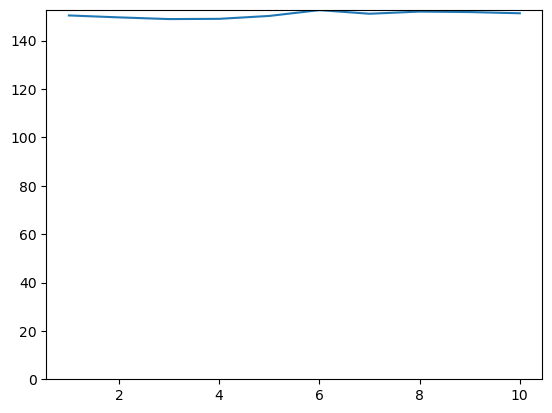

In [82]:
plt.plot(df.period, df.areas)
plt.ylim(0, None)

(0.0, 33584.365)

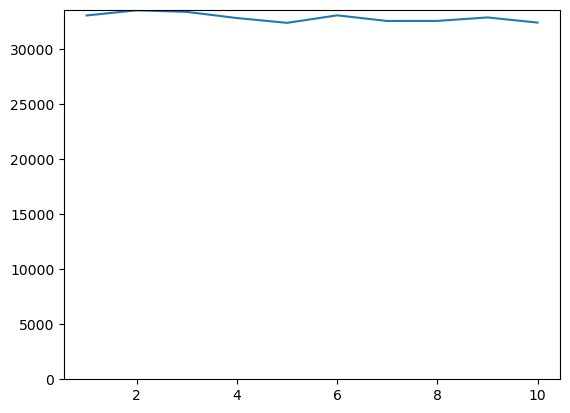

In [83]:
plt.plot(df.period, df.vols)
plt.ylim(0, None)

# Notes and such

Old code from spades_ws3 below, for reference (to not execute this).